In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import geopandas as gpd
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from shapely.geometry import Point, box
import itertools
from operator import itemgetter

import os
from os.path import dirname, abspath


/Users/awilliam/Desktop/wps/api/.venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [3]:
DATASET_FOLDER_PATH = os.path.join(dirname(abspath('')), 'data')

# Simple Dataset: Fire Starts Per Zone

In [4]:
zone_data = os.path.join(DATASET_FOLDER_PATH, 'FIRE_STARTS_PER_ZONE.csv')
with open(zone_data) as file:
    zone_df = pd.read_csv(file)
zone_df['IGNITION_DATE'] = zone_df['IGNITION_DATE'].map(pd.to_datetime)
zone_df['TIMESTAMP'] = zone_df['IGNITION_DATE'].values.astype(np.int64) # 10 ** 9

zone_df.head()


,Unnamed: 0,FIRE_CENTRE,ZONE,IGNITION_DATE,COUNT,TIMESTAMP
0,0,2.0,0.0,1950-05-01,1,-620784000000000000
1,1,2.0,0.0,1950-05-04,1,-620524800000000000
2,2,2.0,0.0,1950-05-12,1,-619833600000000000
3,3,2.0,0.0,1950-05-14,2,-619660800000000000
4,4,2.0,0.0,1950-05-16,7,-619488000000000000


In [5]:
zone_df.drop(columns=['Unnamed: 0', 'IGNITION_DATE'], inplace=True)

In [6]:
zone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81308 entries, 0 to 81307
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FIRE_CENTRE  81308 non-null  float64
 1   ZONE         81308 non-null  float64
 2   COUNT        81308 non-null  int64  
 3   TIMESTAMP    81308 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 2.5 MB


In [7]:
y = zone_df['COUNT']
zone_df.drop(columns=['COUNT'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(zone_df, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.258996


In [9]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='count:poisson', colsample_bytree=0.3, learning_rate=0.1)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))


RMSE: 3.286397
MAE: 1.316663
MAPE: 0.701976


In [10]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='count:poisson', colsample_bytree=0.8, learning_rate=0.6)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))

RMSE: 3.010397
MAE: 1.200146
MAPE: 0.617017


In [11]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.25)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.186046


In [12]:
matrix = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.25)
xg_reg.fit(X_train, y_train)

preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
mape = mean_absolute_percentage_error(y_test, preds)
print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MAPE: %f" % (mape))

RMSE: 3.085485
MAE: 1.227611
MAPE: 0.634403


# Advanced Dataset: Human Fire Starts w/ Locations

In [13]:
campgrounds_source_data = os.path.join(DATASET_FOLDER_PATH, 'BC_MANMADE_POINTS_500M.geojson')
railways_source_data = os.path.join(DATASET_FOLDER_PATH, 'GBA_RAILWAY_TRACKS_SP.geojson')
# roads data extracted in pieces from 
# https://catalogue.data.gov.bc.ca/dataset/digital-road-atlas-dra-demographic-partially-attributed-roads
some_random_roads_source_data = os.path.join(DATASET_FOLDER_PATH, 'DRA_DGTL_ROAD_ATLAS_DPAR_SP.geojson')
some_random_roads_source_data_2 = os.path.join(DATASET_FOLDER_PATH, 'DRA_DGTL_ROAD_ATLAS_DPAR_SP_2.geojson')
some_random_roads_source_data_3 = os.path.join(DATASET_FOLDER_PATH, 'DRA_DGTL_ROAD_ATLAS_DPAR_SP_3.geojson')
some_random_roads_source_data_4 = os.path.join(DATASET_FOLDER_PATH, 'DRA_DGTL_ROAD_ATLAS_DPAR_SP_4.geojson')
some_random_roads_source_data_5 = os.path.join(DATASET_FOLDER_PATH, 'DRA_DGTL_ROAD_ATLAS_DPAR_SP_5.geojson')


with open(railways_source_data) as railways_file:
    railways = gpd.read_file(railways_file)

with open(campgrounds_source_data) as campgrounds_file:
    campgrounds = gpd.read_file(campgrounds_file)

with open(some_random_roads_source_data) as roads_file:
    roads = gpd.read_file(roads_file)

with open(some_random_roads_source_data_2) as roads_file:
    roads_2 = gpd.read_file(roads_file)

with open(some_random_roads_source_data_3) as roads_file:
    roads_3 = gpd.read_file(roads_file)

with open(some_random_roads_source_data_4) as roads_file:
    roads_4 = gpd.read_file(roads_file)

with open(some_random_roads_source_data_5) as roads_file:
    roads_5 = gpd.read_file(roads_file)

roads_df = gpd.GeoDataFrame(pd.concat([roads, roads_2, roads_3, roads_4, roads_5], ignore_index=True))

<AxesSubplot:>

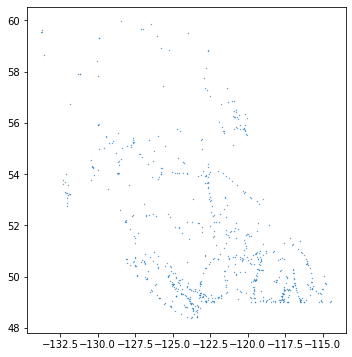

In [14]:
campgrounds.plot(markersize=.1, figsize=(6,6))

<AxesSubplot:>

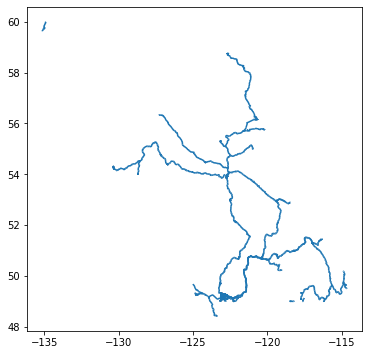

In [15]:
railways.plot(markersize=.1, figsize=(6,6))

<AxesSubplot:>

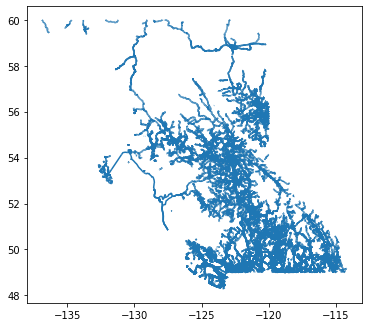

In [16]:
roads_df.plot(markersize=.01, figsize=(6,6))

In [17]:
source_data = os.path.join(DATASET_FOLDER_PATH, 'historical_fires_extra_features.geojson')
with open(source_data) as file:
    df = gpd.read_file(file)

# Apply one-hot encoding to FIRE_CENTRE, ZONE (since they're categorical features)
encoder = OneHotEncoder(handle_unknown='ignore')
encoded_df = pd.DataFrame(encoder.fit_transform(df[['FIRE_CENTRE', 'ZONE']]).toarray())

df = df.join(encoded_df)
df.head()

,FIRE_NUMBER,FIRE_YEAR,IGNITION_DATE,FIRE_CAUSE,FIRE_LABEL,FIRE_CENTRE,ZONE,FIRE_ID,FIRE_TYPE,GEOGRAPHIC_DESCRIPTION,...,28,29,30,31,32,33,34,35,36,37
0,K50756,2013,20130818091300,Person,2013-K50756,5.0,5.0,500756,Nuisance Fire,Darke Lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,K51091,2007,20070807110300,Person,2007-K51091,5.0,5.0,501091,Nuisance Fire,Jack Pine Lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,K51224,2007,20070818162200,Person,2007-K51224,5.0,5.0,501224,Nuisance Fire,Brenda Lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,K51245,2008,20080804121700,Person,2008-K51245,5.0,5.0,501245,Nuisance Fire,Darke lk,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,K50500,2000,20000806210000,Person,2000-K50500,5.0,5.0,500500,Nuisance Fire,Headwaters Lake,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print(df['FIRE_TYPE'].unique())

['Nuisance Fire' 'Fire' 'Nuisance' 'Smoke Chase' 'Field Activity'
 'Unknown' 'Duplicate' 'Agency Assist']


In [19]:
print('Person-caused fires of all types: {}'.format(df.shape[0]))
df = df[df['FIRE_TYPE'] == 'Fire']
print('Person-caused fires of type fire: {}'.format(df.shape[0]))

Person-caused fires of all types: 101694
Person-caused fires of type fire: 78368


<AxesSubplot:>

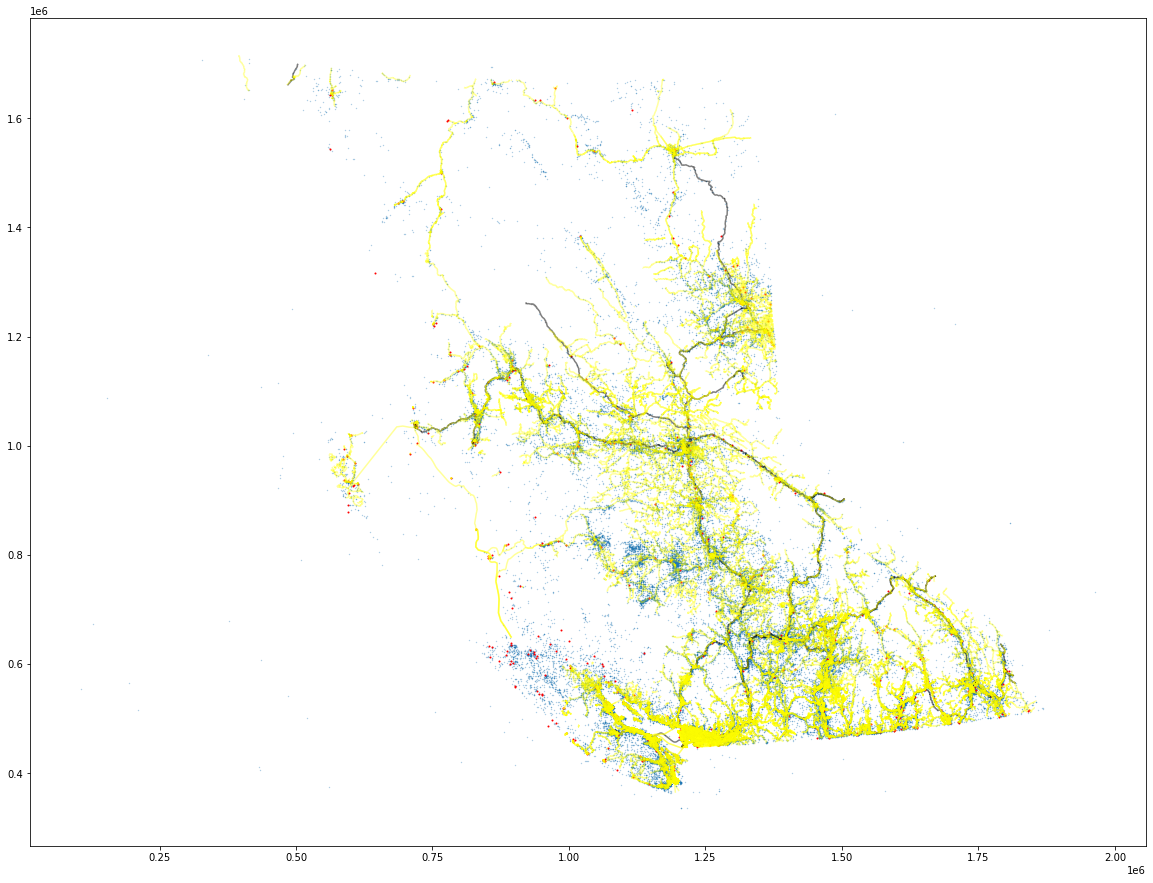

In [20]:
campgrounds = campgrounds.to_crs(df.crs)
railways = railways.to_crs(df.crs)
roads_df = roads_df.to_crs(df.crs)

fig, ax = plt.subplots(figsize=(20,20))
df.plot(ax=ax, alpha=0.5, markersize=.1)
campgrounds.plot(ax=ax, color='red', markersize=1)
railways.plot(ax=ax, color='black', alpha=0.5, markersize=.4)
roads_df.plot(ax=ax, color='yellow', alpha=0.4, markersize=.05)

In [21]:
encoder.get_feature_names_out()

array(['FIRE_CENTRE_2.0', 'FIRE_CENTRE_3.0', 'FIRE_CENTRE_4.0',
       'FIRE_CENTRE_5.0', 'FIRE_CENTRE_6.0', 'FIRE_CENTRE_7.0',
       'ZONE_0.0', 'ZONE_1.0', 'ZONE_2.0', 'ZONE_3.0', 'ZONE_4.0',
       'ZONE_5.0', 'ZONE_6.0', 'ZONE_7.0', 'ZONE_8.0', 'ZONE_9.0',
       'ZONE_10.0', 'ZONE_11.0', 'ZONE_12.0', 'ZONE_13.0', 'ZONE_14.0',
       'ZONE_15.0', 'ZONE_16.0', 'ZONE_17.0', 'ZONE_18.0', 'ZONE_19.0',
       'ZONE_20.0', 'ZONE_21.0', 'ZONE_22.0', 'ZONE_23.0', 'ZONE_24.0',
       'ZONE_25.0', 'ZONE_26.0', 'ZONE_27.0', 'ZONE_28.0', 'ZONE_42.0',
       'ZONE_60.0', 'ZONE_99.0'], dtype=object)

In [22]:
df.drop(columns=['FIRE_CENTRE', 'ZONE'], inplace=True)

df.describe()

,FIRE_YEAR,FIRE_ID,LATITUDE,LONGITUDE,CURRENT_SIZE,distance_to_campground,RAILWAY_TRACK_ID,distance_to_railway,0,1,...,28,29,30,31,32,33,34,35,36,37
count,78368.000000,78368.000000,78368.000000,78368.000000,78343.000000,78368.000000,78368.000000,78368.000000,78368.000000,78368.000000,...,78368.000000,78368.000000,78368.000000,78368.000000,78368.000000,78368.000000,78368.000000,78368.000000,78368.000000,78368.000000
mean,1980.266882,75775.185152,51.400863,-121.876067,44.674046,11134.955695,4888.161558,32345.438154,0.208172,0.082610,...,0.001544,0.004466,0.002960,0.002603,0.000408,0.002233,0.000523,0.000013,0.000013,0.000013
std,18.365029,180335.427073,2.329560,3.211472,1578.704347,13575.585733,2869.539081,48533.425200,0.406003,0.275294,...,0.039264,0.066680,0.054329,0.050954,0.020203,0.047203,0.022867,0.003572,0.003572,0.003572
min,1950.000000,1.000000,48.000000,-139.028000,0.000000,18.937980,1.000000,0.036510,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1966.000000,33.000000,49.568000,-123.878000,0.100000,3546.362681,2494.000000,1878.543779,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1979.000000,129.000000,50.655000,-121.806000,0.100000,7181.613328,5059.000000,10980.534295,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1993.000000,519.000000,52.483000,-119.727575,1.000000,13933.625455,7326.000000,45382.172206,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2021.000000,703166.000000,60.201000,-112.232000,285935.094000,588069.296178,10049.000000,775833.800095,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
print(list(df))

['FIRE_NUMBER', 'FIRE_YEAR', 'IGNITION_DATE', 'FIRE_CAUSE', 'FIRE_LABEL', 'FIRE_ID', 'FIRE_TYPE', 'GEOGRAPHIC_DESCRIPTION', 'LATITUDE', 'LONGITUDE', 'CURRENT_SIZE', 'distance_to_campground', 'RAILWAY_TRACK_ID', 'TRACK_CLASSIFICATION', 'USE_TYPE', 'STATUS', 'OPERATOR_ENGLISH_NAME', 'OWNER_NAME', 'SUBDIVISION1_NAME', 'distance_to_railway', 'geometry', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


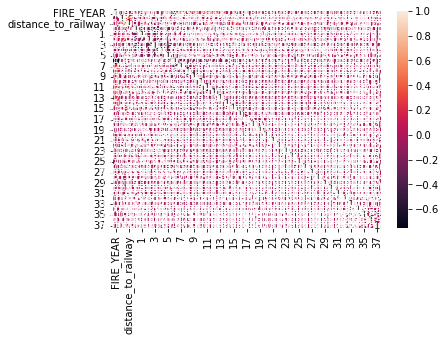

In [24]:
corr_df = df[['FIRE_YEAR', 'distance_to_campground', 'distance_to_railway', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]]

corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [25]:
corr_matrix[corr_matrix < 1].unstack().transpose().sort_values(ascending=False).drop_duplicates()

distance_to_campground  distance_to_railway    0.352972
FIRE_YEAR               11                     0.256912
15                      distance_to_railway    0.254009
FIRE_YEAR               7                      0.247054
distance_to_railway     11                     0.242689
                                                 ...   
4                       3                     -0.246417
5                       3                     -0.265263
0                       3                     -0.308162
6                       FIRE_YEAR             -0.755399
FIRE_YEAR               FIRE_YEAR                   NaN
Length: 819, dtype: float64

In [26]:
def calculate_distance_to_nearest_linestring(gdfA, gdfB, gdfB_cols=['geometry']):
    # Returns distance (in metres) from list of Points to nearest railway track or road (LineString)
    # code from https://gis.stackexchange.com/a/301935
    A = np.concatenate(
        [np.array(geom.coords) for geom in gdfA.geometry.to_list()])
    B = [np.array(geom.coords) for geom in gdfB.geometry.to_list()]
    B_ix = tuple(itertools.chain.from_iterable(
        [itertools.repeat(i, x) for i, x in enumerate(list(map(len, B)))]))
    B = np.concatenate(B)
    ckd_tree = cKDTree(B)
    dist, idx = ckd_tree.query(A, k=1)
    idx = itemgetter(*idx)(B_ix)
    gdf = pd.concat(
        [gdfA, gdfB.loc[idx, gdfB_cols].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

In [27]:
def calculate_distance_to_nearest_point(gdA, gdB):
    # Returns distance (in metres) from list of Points to nearest campground (Point)
    # code from https://gis.stackexchange.com/a/301935
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf
    

In [28]:
# turn each Planning Area in each Fire Centre into a grid of points
# then for each point in the grid, calculate its distance to nearest campground and railway and road
# then for each point and a selected date, estimate number of fires that will occur for that date within that grid (around that point)
    # BUCKET THE POINTS IN THE FIRES DATASET INTO SMALLER GRIDS, THEN COLLECT NUMBER OF FIRE STARTS PER DAY FOR EACH GRID
    # AND USE CENTROID OF GRID AS POINT TO REPRESENT ENTIRE GRID?
# wrap those points together and output estimated number of fire starts for each planning area

In [29]:
xmin, ymin, xmax, ymax = roads_df.total_bounds
print(xmin, ymin, xmax, ymax)

395112.217700002 364282.2006000011 1856289.501699999 1714984.871600001


In [30]:
cell_size = 10000 # in metres. 10000m = 10km
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        x1 = x0 + cell_size
        y1 = y0 + cell_size
        grid_cells.append(box(x0, y0, x1, y1))
cell = gpd.GeoDataFrame(grid_cells, crs=roads_df.crs, columns=['geometry'])

cells_and_railways = cell.sjoin_nearest(railways, distance_col="distance_to_railway")
cells_and_campgrounds = cell.sjoin_nearest(campgrounds, distance_col="distance_to_campground")
cells_and_roads = cell.sjoin_nearest(roads_df, distance_col="distance_to_road")

In [31]:
cells_and_railways.head()

,geometry,index_right,RAILWAY_TRACK_ID,NID,TRACK_SEGMENT_ID,TRACK_NAME,TRACK_CLASSIFICATION,REGULATOR,TRANSPORT_TYPE,USE_TYPE,...,ATTRIBUTE_CREATION_DATE,ATTRIBUTE_REVISION_DATE,ATTRIBUTE_ACQUISITION_TECHNQUE,ATTRIBUTE_PROVIDER,OBJECTID,SE_ANNO_CAD_DATA,FEATURE_LENGTH_M,SHAPE.LEN,fme_feature_type,distance_to_railway
0,"POLYGON ((405112.218 364282.201, 405112.218 37...",9134,8239,2dbe386fcba54f10afe3ed40554f23ad,222a5259cadc4bf8838a20cffdf60c53,None,Siding,Unknown,Train,Freight and Passenger,...,20170101,20170101,Vector Data,Federal,2208729,None,118.3444,0,WHSE_BASEMAPPING.GBA_RAILWAY_TRACKS_SP,682361.325657
1,"POLYGON ((405112.218 374282.201, 405112.218 38...",9134,8239,2dbe386fcba54f10afe3ed40554f23ad,222a5259cadc4bf8838a20cffdf60c53,None,Siding,Unknown,Train,Freight and Passenger,...,20170101,20170101,Vector Data,Federal,2208729,None,118.3444,0,WHSE_BASEMAPPING.GBA_RAILWAY_TRACKS_SP,680307.799152
2,"POLYGON ((405112.218 384282.201, 405112.218 39...",9134,8239,2dbe386fcba54f10afe3ed40554f23ad,222a5259cadc4bf8838a20cffdf60c53,None,Siding,Unknown,Train,Freight and Passenger,...,20170101,20170101,Vector Data,Federal,2208729,None,118.3444,0,WHSE_BASEMAPPING.GBA_RAILWAY_TRACKS_SP,678395.477889
3,"POLYGON ((405112.218 394282.201, 405112.218 40...",9134,8239,2dbe386fcba54f10afe3ed40554f23ad,222a5259cadc4bf8838a20cffdf60c53,None,Siding,Unknown,Train,Freight and Passenger,...,20170101,20170101,Vector Data,Federal,2208729,None,118.3444,0,WHSE_BASEMAPPING.GBA_RAILWAY_TRACKS_SP,676625.559120
4,"POLYGON ((405112.218 404282.201, 405112.218 41...",9134,8239,2dbe386fcba54f10afe3ed40554f23ad,222a5259cadc4bf8838a20cffdf60c53,None,Siding,Unknown,Train,Freight and Passenger,...,20170101,20170101,Vector Data,Federal,2208729,None,118.3444,0,WHSE_BASEMAPPING.GBA_RAILWAY_TRACKS_SP,674999.163028


In [32]:
print(list(cells_and_railways))

['geometry', 'index_right', 'RAILWAY_TRACK_ID', 'NID', 'TRACK_SEGMENT_ID', 'TRACK_NAME', 'TRACK_CLASSIFICATION', 'REGULATOR', 'TRANSPORT_TYPE', 'USE_TYPE', 'GAUGE', 'NUMBER_OF_TRACKS', 'ELECTRIFICATION', 'STATUS', 'DESIGN_SPEED_FREIGHT', 'DESIGN_SPEED_PASSENGER', 'SOURCE_ID', 'OPERATOR_ENGLISH_NAME', 'OPERATOR_SUBDIV_PORTION_START', 'OPERATOR_SUBDIV_PORTION_END', 'OWNER_NAME', 'TRACK_USER1_ENGLISH_NAME', 'TRACK_USER2_ENGLISH_NAME', 'TRACK_USER3_ENGLISH_NAME', 'TRACK_USER4_ENGLISH_NAME', 'SUBDIVISION1_NID', 'SUBDIVISION1_NAME', 'SUBDIVISION1_START', 'SUBDIVISION1_END', 'SUBDIVISION2_NID', 'SUBDIVISION2_NAME', 'SUBDIVISION2_START', 'SUBDIVISION2_END', 'ADMINISTRATIVE_AREA', 'STANDARDS_VERSION', 'SECURITY_CLASSIFICATION', 'GEOMETRY_CREATION_DATE', 'GEOMETRY_REVISION_DATE', 'GEOMETRY_ACQUISITION_TECHNQUE', 'GEOMETRY_PLANIMETRIC_ACCURACY', 'GEOMETRY_PROVIDER', 'ATTRIBUTE_CREATION_DATE', 'ATTRIBUTE_REVISION_DATE', 'ATTRIBUTE_ACQUISITION_TECHNQUE', 'ATTRIBUTE_PROVIDER', 'OBJECTID', 'SE_ANNO_C

In [33]:
cells_and_railways.drop(columns=['index_right', 'NID', 'SOURCE_ID', 'SUBDIVISION1_NID', 'SUBDIVISION1_START', 'SUBDIVISION1_END', 'SUBDIVISION2_NID', 'SUBDIVISION2_NAME', 'SUBDIVISION2_START', 'SUBDIVISION2_END', 'STANDARDS_VERSION', 'GEOMETRY_CREATION_DATE', 'GEOMETRY_REVISION_DATE', 'GEOMETRY_ACQUISITION_TECHNQUE', 'GEOMETRY_PLANIMETRIC_ACCURACY', 'GEOMETRY_PROVIDER', 'ATTRIBUTE_CREATION_DATE', 'ATTRIBUTE_REVISION_DATE', 'ATTRIBUTE_ACQUISITION_TECHNQUE', 'ATTRIBUTE_PROVIDER', 'SE_ANNO_CAD_DATA', 'FEATURE_LENGTH_M', 'SHAPE.LEN', 'fme_feature_type', 'TRACK_USER1_ENGLISH_NAME', 'TRACK_USER2_ENGLISH_NAME', 'TRACK_USER3_ENGLISH_NAME', 'TRACK_USER4_ENGLISH_NAME', 'ADMINISTRATIVE_AREA', 'SECURITY_CLASSIFICATION', 'OBJECTID', 'ELECTRIFICATION', 'DESIGN_SPEED_FREIGHT', 'DESIGN_SPEED_PASSENGER', 'OPERATOR_SUBDIV_PORTION_END', 'OPERATOR_SUBDIV_PORTION_START', 'REGULATOR', 'TRANSPORT_TYPE', 'GAUGE', 'NUMBER_OF_TRACKS', 'TRACK_NAME'], inplace=True)

In [34]:
cells_and_roads.head()

,geometry,index_right,DIGITAL_ROAD_ATLAS_LINE_ID,FEATURE_TYPE,HIGHWAY_EXIT_NUMBER,HIGHWAY_ROUTE_NUMBER,SEGMENT_LENGTH_2D,SEGMENT_LENGTH_3D,ROAD_NAME_ALIAS1,ROAD_NAME_ALIAS1_ID,...,SUPPLIER_DETAIL,GEOMETRY_CAPTURE_TECHNIQUE,DATA_CAPTURE_DATE,FEATURE_CODE,OBJECTID,SE_ANNO_CAD_DATA,FEATURE_LENGTH_M,GEOMETRY.LEN,fme_feature_type,distance_to_road
0,"POLYGON ((405112.218 364282.201, 405112.218 37...",435430,2424835,Road,None,None,1217.732,None,None,NaN,...,Contractor - DSM Soft,satelliteImagery,20170804,None,35460033,None,1217.7317,0,WHSE_BASEMAPPING.DRA_DGTL_ROAD_ATLAS_DPAR_SP,555756.154632
1,"POLYGON ((405112.218 374282.201, 405112.218 38...",435430,2424835,Road,None,None,1217.732,None,None,NaN,...,Contractor - DSM Soft,satelliteImagery,20170804,None,35460033,None,1217.7317,0,WHSE_BASEMAPPING.DRA_DGTL_ROAD_ATLAS_DPAR_SP,546465.646195
2,"POLYGON ((405112.218 384282.201, 405112.218 39...",435430,2424835,Road,None,None,1217.732,None,None,NaN,...,Contractor - DSM Soft,satelliteImagery,20170804,None,35460033,None,1217.7317,0,WHSE_BASEMAPPING.DRA_DGTL_ROAD_ATLAS_DPAR_SP,537200.615721
3,"POLYGON ((405112.218 394282.201, 405112.218 40...",435430,2424835,Road,None,None,1217.732,None,None,NaN,...,Contractor - DSM Soft,satelliteImagery,20170804,None,35460033,None,1217.7317,0,WHSE_BASEMAPPING.DRA_DGTL_ROAD_ATLAS_DPAR_SP,527962.404525
4,"POLYGON ((405112.218 404282.201, 405112.218 41...",435430,2424835,Road,None,None,1217.732,None,None,NaN,...,Contractor - DSM Soft,satelliteImagery,20170804,None,35460033,None,1217.7317,0,WHSE_BASEMAPPING.DRA_DGTL_ROAD_ATLAS_DPAR_SP,518752.445441


In [35]:
print(list(cells_and_roads))

['geometry', 'index_right', 'DIGITAL_ROAD_ATLAS_LINE_ID', 'FEATURE_TYPE', 'HIGHWAY_EXIT_NUMBER', 'HIGHWAY_ROUTE_NUMBER', 'SEGMENT_LENGTH_2D', 'SEGMENT_LENGTH_3D', 'ROAD_NAME_ALIAS1', 'ROAD_NAME_ALIAS1_ID', 'ROAD_NAME_ALIAS2', 'ROAD_NAME_ALIAS2_ID', 'ROAD_NAME_ALIAS3', 'ROAD_NAME_ALIAS3_ID', 'ROAD_NAME_ALIAS4', 'ROAD_NAME_ALIAS4_ID', 'ROAD_NAME_FULL', 'ROAD_NAME_ID', 'ROAD_SURFACE', 'ROAD_CLASS', 'NUMBER_OF_LANES', 'NODE_FROM_ID', 'NODE_TO_ID', 'DATA_SUPPLIER', 'SUPPLIER_DETAIL', 'GEOMETRY_CAPTURE_TECHNIQUE', 'DATA_CAPTURE_DATE', 'FEATURE_CODE', 'OBJECTID', 'SE_ANNO_CAD_DATA', 'FEATURE_LENGTH_M', 'GEOMETRY.LEN', 'fme_feature_type', 'distance_to_road']


In [36]:
cells_and_roads.drop(columns=['index_right', 'HIGHWAY_EXIT_NUMBER', 'HIGHWAY_ROUTE_NUMBER', 'SEGMENT_LENGTH_2D', 'SEGMENT_LENGTH_3D', 'ROAD_NAME_ALIAS1', 'ROAD_NAME_ALIAS1_ID', 'ROAD_NAME_ALIAS2', 'ROAD_NAME_ALIAS2_ID', 'ROAD_NAME_ALIAS3', 'ROAD_NAME_ALIAS3_ID', 'ROAD_NAME_ALIAS4', 'ROAD_NAME_ALIAS4_ID', 'ROAD_NAME_FULL', 'ROAD_NAME_ID', 'ROAD_SURFACE', 'NUMBER_OF_LANES', 'NODE_FROM_ID', 'NODE_TO_ID', 'DATA_SUPPLIER', 'SUPPLIER_DETAIL', 'GEOMETRY_CAPTURE_TECHNIQUE', 'DATA_CAPTURE_DATE', 'FEATURE_CODE', 'OBJECTID', 'SE_ANNO_CAD_DATA', 'FEATURE_LENGTH_M', 'GEOMETRY.LEN', 'fme_feature_type'], inplace=True)

In [37]:
cells_and_campgrounds.head()

,geometry,index_right,FCODE,OBJECTID,SE_ANNO_CAD_DATA,fme_feature_type,distance_to_campground
0,"POLYGON ((405112.218 364282.201, 405112.218 37...",98,AR03400100,99,None,WHSE_BASEMAPPING.BC_MANMADE_POINTS_500M,509438.839794
1,"POLYGON ((405112.218 374282.201, 405112.218 38...",98,AR03400100,99,None,WHSE_BASEMAPPING.BC_MANMADE_POINTS_500M,504812.307202
2,"POLYGON ((405112.218 384282.201, 405112.218 39...",98,AR03400100,99,None,WHSE_BASEMAPPING.BC_MANMADE_POINTS_500M,500342.881947
3,"POLYGON ((405112.218 394282.201, 405112.218 40...",98,AR03400100,99,None,WHSE_BASEMAPPING.BC_MANMADE_POINTS_500M,496034.810802
4,"POLYGON ((405112.218 404282.201, 405112.218 41...",98,AR03400100,99,None,WHSE_BASEMAPPING.BC_MANMADE_POINTS_500M,491892.333279


In [38]:
print(list(cells_and_campgrounds))

['geometry', 'index_right', 'FCODE', 'OBJECTID', 'SE_ANNO_CAD_DATA', 'fme_feature_type', 'distance_to_campground']


In [39]:
cells_and_campgrounds.drop(columns=['index_right', 'OBJECTID', 'SE_ANNO_CAD_DATA', 'fme_feature_type'], inplace=True)

In [40]:
cells = pd.merge(cells_and_campgrounds, cells_and_railways, how='outer', on='geometry')
cells = pd.merge(cells, cells_and_roads, how='outer', on='geometry')

cells.head()

,geometry,FCODE,distance_to_campground,RAILWAY_TRACK_ID,TRACK_SEGMENT_ID,TRACK_CLASSIFICATION,USE_TYPE,STATUS,OPERATOR_ENGLISH_NAME,OWNER_NAME,SUBDIVISION1_NAME,distance_to_railway,DIGITAL_ROAD_ATLAS_LINE_ID,FEATURE_TYPE,ROAD_CLASS,distance_to_road
0,"POLYGON ((405112.218 364282.201, 405112.218 37...",AR03400100,509438.839794,8239,222a5259cadc4bf8838a20cffdf60c53,Siding,Freight and Passenger,Operational,Southern Railway of Vancouver Island,Island Corridor Foundation,Victoria,682361.325657,2424835,Road,resource,555756.154632
1,"POLYGON ((405112.218 374282.201, 405112.218 38...",AR03400100,504812.307202,8239,222a5259cadc4bf8838a20cffdf60c53,Siding,Freight and Passenger,Operational,Southern Railway of Vancouver Island,Island Corridor Foundation,Victoria,680307.799152,2424835,Road,resource,546465.646195
2,"POLYGON ((405112.218 384282.201, 405112.218 39...",AR03400100,500342.881947,8239,222a5259cadc4bf8838a20cffdf60c53,Siding,Freight and Passenger,Operational,Southern Railway of Vancouver Island,Island Corridor Foundation,Victoria,678395.477889,2424835,Road,resource,537200.615721
3,"POLYGON ((405112.218 394282.201, 405112.218 40...",AR03400100,496034.810802,8239,222a5259cadc4bf8838a20cffdf60c53,Siding,Freight and Passenger,Operational,Southern Railway of Vancouver Island,Island Corridor Foundation,Victoria,676625.559120,2424835,Road,resource,527962.404525
4,"POLYGON ((405112.218 404282.201, 405112.218 41...",AR03400100,491892.333279,8239,222a5259cadc4bf8838a20cffdf60c53,Siding,Freight and Passenger,Operational,Southern Railway of Vancouver Island,Island Corridor Foundation,Victoria,674999.163028,2424835,Road,resource,518752.445441


In [41]:
merged = gpd.sjoin(df, cells, how='left', predicate='within')

merged.head()

: 

: 